In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src import train, generate, eval
from src.train import make_inference_model
from src.pipeline_util import load_bnn
from src.modules.config import read_config
import src.modules.plots as plots
from src.modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

#BASE_DIR = "../tests/dataset-tests/sineasy10-10k-s05/"
#PROFILE = "sineasy10-3x128-s05"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["EPOCHS"] = "10"
config["DEVICE"] = "cpu"
config["RERUNS"] = "1"
config["HIDDEN_FEATURES"] = "[]"
config["GUIDE_SCALE"] = "0.001"


config["LIKELIHOOD_SCALE_LOC"] = "1.0"
config["OBS_MODEL"] = "homoskedastic_gamma"
config["LIKELIHOOD_SCALE"] = "1.0"



dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["SIGMA"] = "0.8"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -3.3443794483513587 - 3.057224599555369
In Domain: (-10, 10)
Y-space: -3.076650198826965 - 2.8018772258827322
Out Domain: (-20, 20)
Y-space: -2.5940238150635797 - 3.4086463668516838


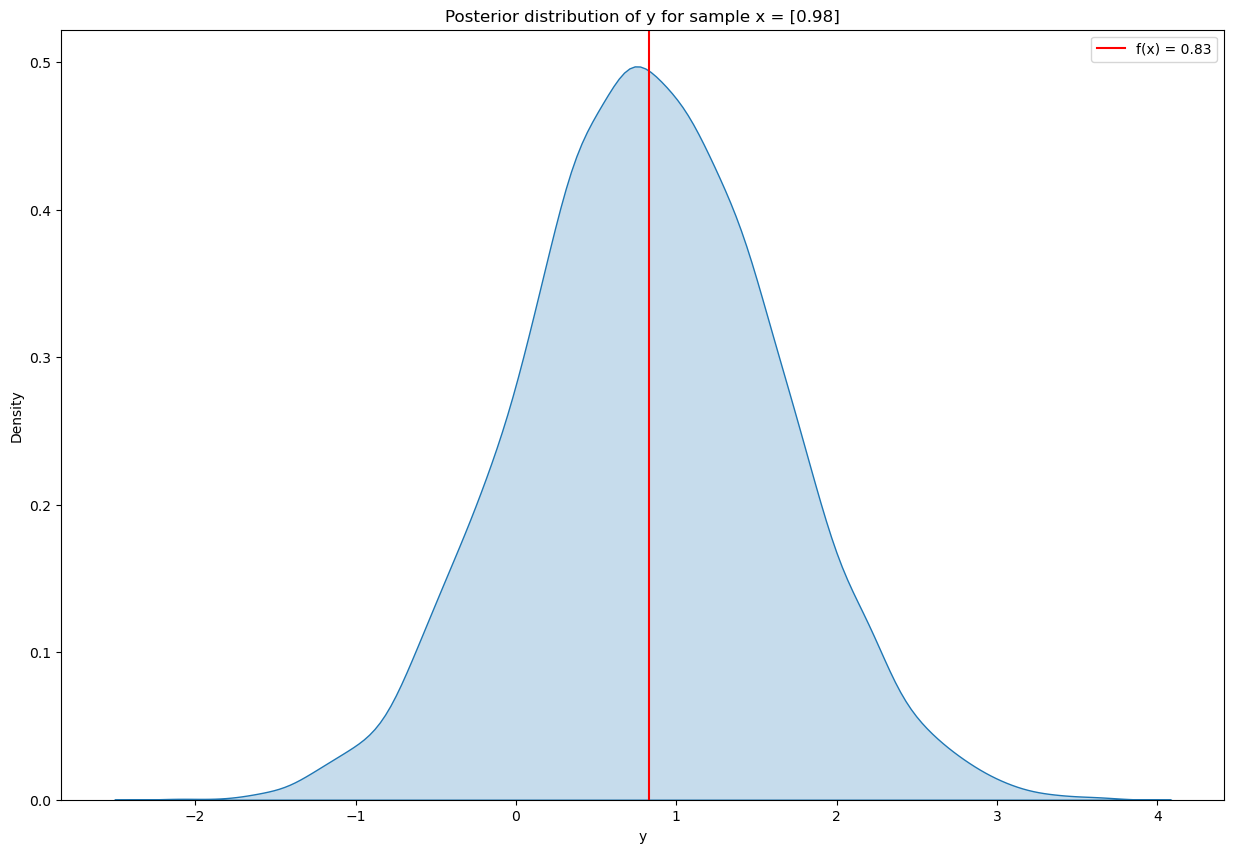

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


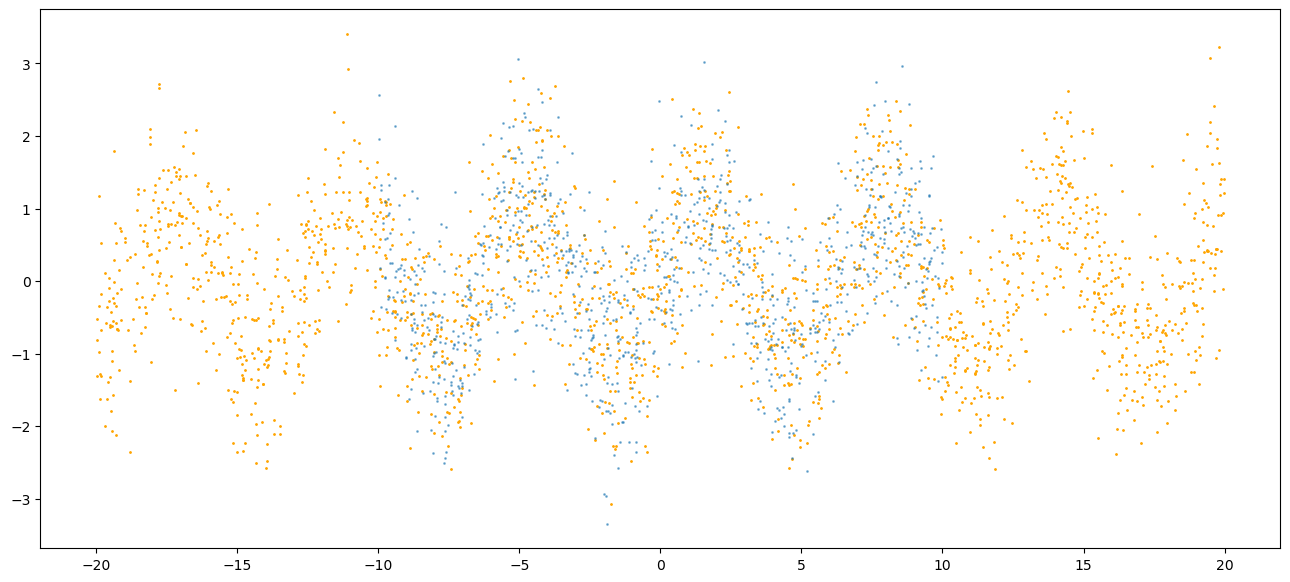

In [8]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
    plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [9]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

Cuda Devices: []
torch.Size([128, 1]) torch.Size([128, 1])
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 1000
Using device: cpu
===== Training profile tyxe-test - 1 =====
loc torch.Size([100, 512, 1])
std torch.Size([100])
loc torch.Size([512, 1])
std tensor(3.0787)
pred var tensor([[1.4671e-05],
        [3.8739e-05],
        [1.3671e-05],
        [2.8652e-06],
        [5.3511e-05],
        [3.3922e-06],
        [6.7158e-05],
        [3.7370e-06],
        [6.5160e-05],
        [8.2800e-07],
        [5.9250e-06],
        [5.7700e-05],
        [2.7479e-06],
        [6.8132e-05],
        [9.9701e-05],
        [2.2717e-05],
        [1.6123e-05],
        [8.1635e-07],
        [1.2666e-06],
        [2.9814e-05],
        [2.0109e-05],
        [7.4528e-05],
        [1.0272e-04],
        [5.6036e-05],
        [1.2188e-06],
        [2.2750e-06],
        [1.883

In [10]:
params = pyro.get_param_store()
params.keys()

dict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale'])

In [11]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt")

Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 1000
loc torch.Size([1, 1, 1])
std torch.Size([1])
loc torch.Size([1, 1])
std tensor(2.9849)
pred var tensor([[nan]])
std tensor([[nan]])
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt


In [12]:
preds2 = bnn.predict(x_test, num_predictions=100, aggregate=False)

In [13]:
dummy_input = torch.randn(1, 1)
weights = bnn.get_weight_distributions()
weights.keys()

dict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale'])

In [14]:
#collect all weights in a list
weight_scale_list = []
for name, data in weights.items():
    if "scale" in name:
        print(name, data.reshape(-1).shape)
        weight_scale_list.append(data.reshape(-1))
weight_scale_list = torch.cat(weight_scale_list)
weight_scale_list.mean()




net_guide.net.0.weight.scale torch.Size([1])
net_guide.net.0.bias.scale torch.Size([1])
likelihood_guide.likelihood._scale.loc torch.Size([1])
likelihood_guide.likelihood._scale.scale torch.Size([1])


tensor(0.2863, grad_fn=<MeanBackward0>)

In [15]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
p = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=False)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

loc torch.Size([1000, 2000, 1])
std torch.Size([1000])
loc torch.Size([2000, 1])
std tensor(2.8445)
pred var tensor([[0.0005],
        [0.0005],
        [0.0005],
        ...,
        [0.0004],
        [0.0005],
        [0.0005]])
std tensor([[2.8446],
        [2.8446],
        [2.8446],
        ...,
        [2.8446],
        [2.8446],
        [2.8446]])


In [16]:
stds

tensor([[2.8446],
        [2.8446],
        [2.8446],
        ...,
        [2.8446],
        [2.8446],
        [2.8446]])

In [17]:
print(means[0])
print(p[:, 0].mean())

tensor([-2.1199])
tensor(-2.1184)


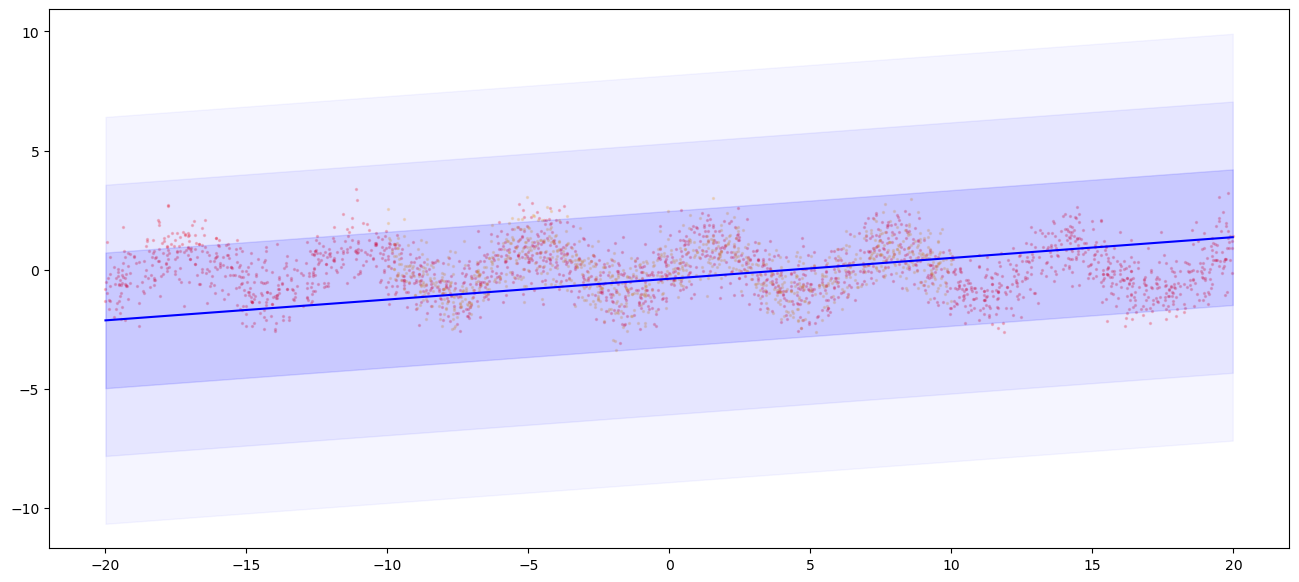

In [18]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    plt.plot(x_test[test_sort], means, color="blue")
    #plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
    for c in range(1, 4):
        plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

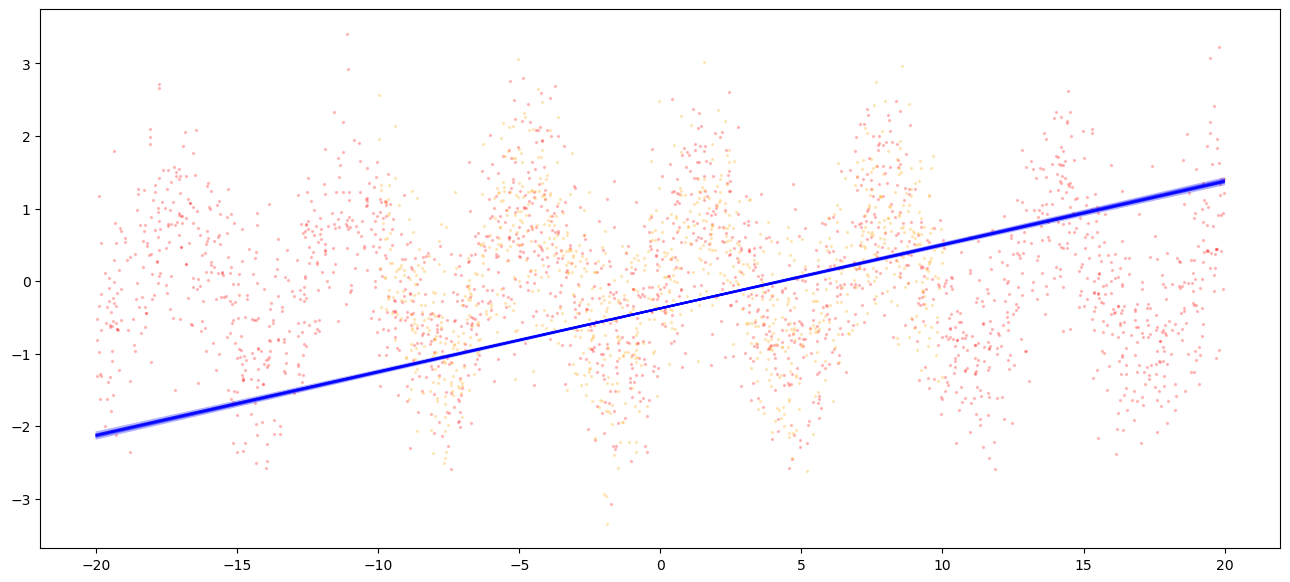

In [19]:
if dataset_config["X_DIM"] == "1":
    sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=15, aggregate=False)
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    for yhat in sampled_predictions:
        plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [20]:

if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None, reruns=config.getint("RERUNS"))

data samples:  (1000, 1000)
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 1000
loc torch.Size([1, 1, 1])
std torch.Size([1])
loc torch.Size([1, 1])
std tensor(2.5629)
pred var tensor([[nan]])
std tensor([[nan]])
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt
using device: cpu
====== evaluating profile tyxe-test - 1 ======
pred samples:  (1000, 1000)
Evaluating train...
loc torch.Size([1000, 512, 1])
std torch.Size([1000])
loc torch.Size([512, 1])
std tensor(2.8518)
pred var tensor([[3.8860e-05],
        [1.6469e-06],
        [1.9705e-06],
        [3.5494e-05],
        [5.4168e-05],
        [8.5191e-06],
        [3.3586e-06],
        [1.2886e-06],
        [2.7284e-06],
        [9.2315e-05],
        [7.3943e-06],
        [5.4679e-05],
        [9.9537e-05],
        [2.0266e-05],
        [9.4776e-06],
        [2.8802e-06],
 

In [21]:
profiles= [PROFILE]

colors = ["green"]

names = [configs[p]["NAME"] for p in profiles]

In [22]:
from IPython.display import display, HTML

train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats_1.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results_1.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

In [23]:
train_stats

{'tyxe-test': {'elbos': [275.10658073425293,
   268.1287384033203,
   274.4738655090332,
   265.18414878845215,
   272.5397186279297,
   263.1684970855713,
   263.85948944091797,
   265.7985019683838,
   269.81861114501953,
   254.6836338043213],
  'time': 5.92557692527771,
  'val_rmse': [1.3554415702819824],
  'val_ll': [-2.1444101333618164],
  'train_rmse': [1.3807008266448975],
  'train_ll': [-2.132817029953003],
  'likelihood': {'mean': 2.766216993331909, 'std': 0.3123161494731903}}}

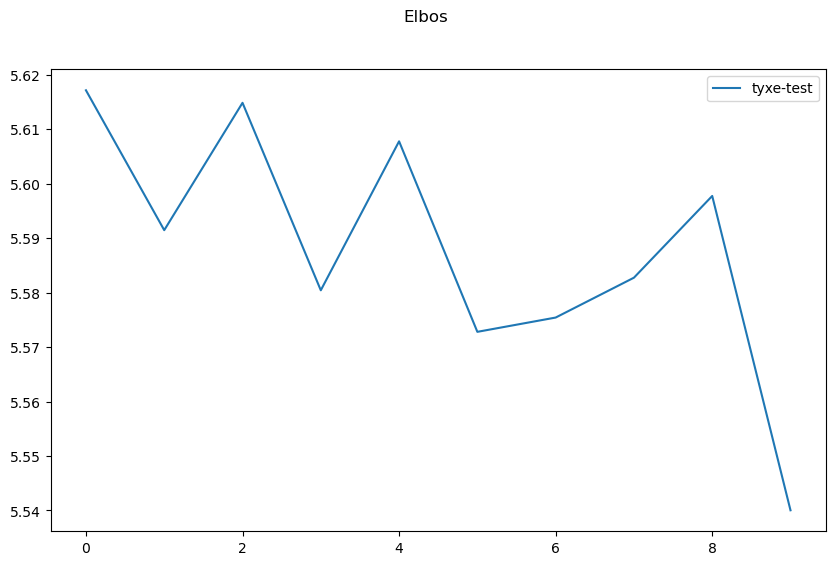

In [24]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Elbos")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["elbos"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("MSE loss")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["loss"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()


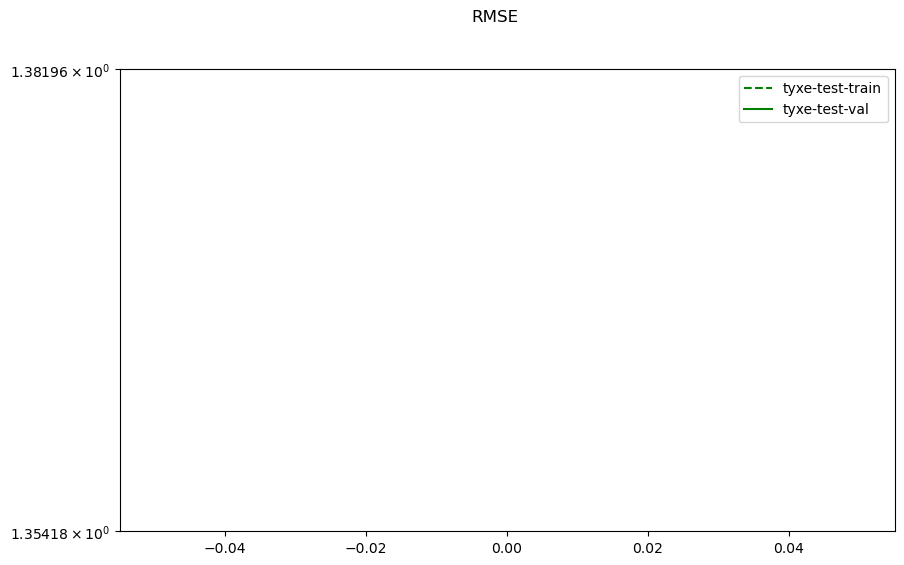

In [25]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("RMSE")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        te = train_stats[name]["train_rmse"]
        ax.plot(te, '--', label=f"{name}-train", color=colors[i])
        ve = train_stats[name]["val_rmse"]
        ax.plot(ve, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', base=10)
    ax.legend()
    plt.show()

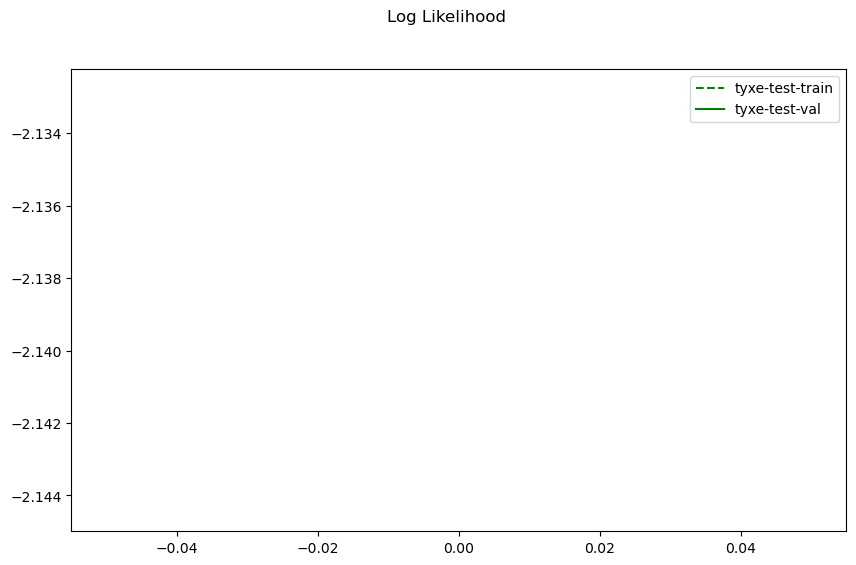

In [26]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Log Likelihood")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        tll = train_stats[name]["train_ll"]
        ax.plot(tll, '--', label=f"{name}-train", color=colors[i])
        vll = train_stats[name]["val_ll"]
        ax.plot(vll, label=f"{name}-val", color=colors[i])
    ax.legend()
    plt.show()

In [27]:
name1 = configs[profiles[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}

In [28]:
trace = poutine.trace(bnn.guide, param_only=True).get_trace(torch.ones(1, 1))
for name, value in trace.nodes.items():
    print(name, value["value"])

net_guide.net.0.weight.loc Parameter containing:
tensor([[0.0872]], requires_grad=True)
net_guide.net.0.weight.scale tensor([[0.0011]], grad_fn=<AddBackward0>)
net_guide.net.0.bias.loc Parameter containing:
tensor([-0.3748], requires_grad=True)
net_guide.net.0.bias.scale tensor([0.0011], grad_fn=<AddBackward0>)
likelihood_guide.likelihood._scale.loc Parameter containing:
tensor(1.0431, requires_grad=True)
likelihood_guide.likelihood._scale.scale tensor(0.1001, grad_fn=<AddBackward0>)


In [29]:
preds = bnn.predict(x_train, num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

loc torch.Size([1000, 1000, 1])
std torch.Size([1000])
loc torch.Size([1000, 1])
std tensor(2.8583)
pred var tensor([[2.2807e-06],
        [2.3430e-05],
        [6.2637e-06],
        [2.0984e-06],
        [3.6662e-06],
        [1.1433e-05],
        [2.7774e-06],
        [7.4582e-05],
        [1.0387e-04],
        [7.2634e-06],
        [4.1971e-05],
        [1.5076e-06],
        [3.3840e-06],
        [8.7753e-05],
        [8.7425e-05],
        [8.1035e-05],
        [1.0921e-04],
        [5.4154e-05],
        [3.8279e-05],
        [6.6681e-05],
        [1.1058e-04],
        [4.4068e-05],
        [1.6817e-06],
        [3.8912e-05],
        [6.9366e-05],
        [1.0612e-05],
        [6.0639e-05],
        [9.5658e-05],
        [1.3242e-06],
        [4.3376e-06],
        [2.6864e-05],
        [3.7244e-05],
        [1.8792e-06],
        [3.4100e-06],
        [1.0986e-04],
        [7.8468e-06],
        [7.2326e-06],
        [7.7674e-06],
        [9.5269e-05],
        [1.7084e-05],
        [1.

In [30]:
np.mean([0.5841, 0.2401, 0.5373, 0.3512, 1.0509, 1.1938, 0.9852, 0.7449, 0.1956,
        0.1935, 0.2736, 0.5974, 0.5109, 0.1690, 0.4012, 0.2088, 1.1079, 0.1928,
        2.2797, 1.3872, 0.8574, 1.2075, 1.0365, 1.0397, 0.2211, 0.5180, 0.6681,
        0.6494, 5.3928, 0.4401, 3.8093, 2.6091, 2.7715, 0.1101, 0.4835, 0.9445,
        1.1373, 0.2392, 0.3103, 1.8791, 0.7320, 0.7077, 0.8456, 0.4358, 0.7210,
        1.5224, 0.3728, 1.1524, 0.2543, 2.2599])

0.97067

In [31]:
np.std([0.5841, 0.2401, 0.5373, 0.3512, 1.0509, 1.1938, 0.9852, 0.7449, 0.1956,
        0.1935, 0.2736, 0.5974, 0.5109, 0.1690, 0.4012, 0.2088, 1.1079, 0.1928,
        2.2797, 1.3872, 0.8574, 1.2075, 1.0365, 1.0397, 0.2211, 0.5180, 0.6681,
        0.6494, 5.3928, 0.4401, 3.8093, 2.6091, 2.7715, 0.1101, 0.4835, 0.9445,
        1.1373, 0.2392, 0.3103, 1.8791, 0.7320, 0.7077, 0.8456, 0.4358, 0.7210,
        1.5224, 0.3728, 1.1524, 0.2543, 2.2599])

0.9847489225685906